In [50]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
data = pd.read_csv('raw_fpn/587476e3b807da0011e33cee.csv')

In [52]:
list_data = data.values.tolist()

In [53]:
for i,data in enumerate(list_data):
    filename = data[0]
    subStr = re.findall(r'_time_(.+?).jpg',filename)  
    t1 = datetime.strptime(subStr[0], "%Y_%m_%d_%H_%M")
    data.append(t1)
    list_data[i] = data

columns = ['filename', '1',  '2' ,'3' ,'4' ,'5' ,'6' ,'7' ,'8' ,'time']
preprocess = pd.DataFrame(list_data , columns = columns)
preprocess = preprocess.sort_values(by='time',ascending=True)

In [54]:
columns = ['filename', 'motobike', 'car' ,'bus', 'train' ,'truck' ,'time']
preprocess = pd.DataFrame(list(np.array(list_data)[:,[0,1,3,6,7,8,9]]) , columns = columns)
preprocess = preprocess.sort_values(by='time',ascending=True)

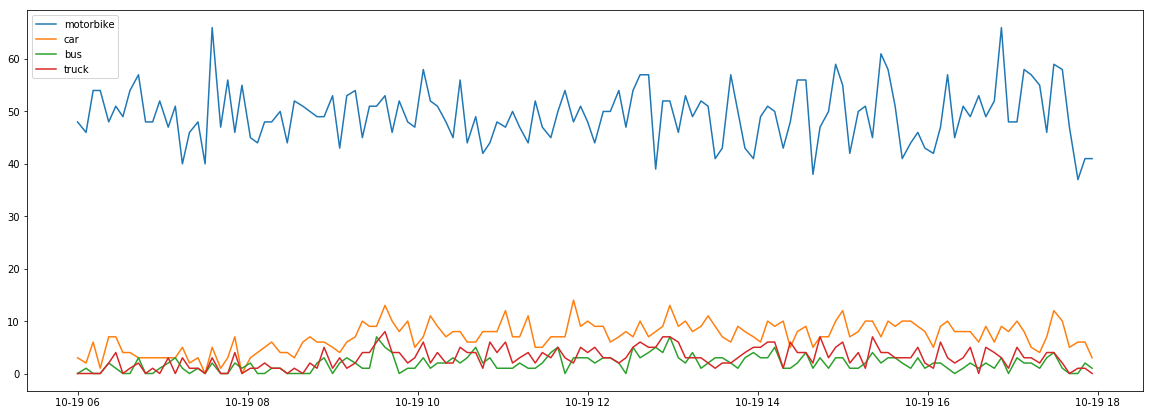

In [55]:
day_cond = 19
month_cond = 10
index_list = []
for index in preprocess['time'].astype('O').index:
    day = preprocess['time'].astype('O')[index]
    if day.day == day_cond and day.month == month_cond:
        index_list.append(index) 
        
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['motobike'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['car'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['bus'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['truck'].astype(int)[index_list])
plt.legend(['motorbike','car','bus','truck'])
plt.show()

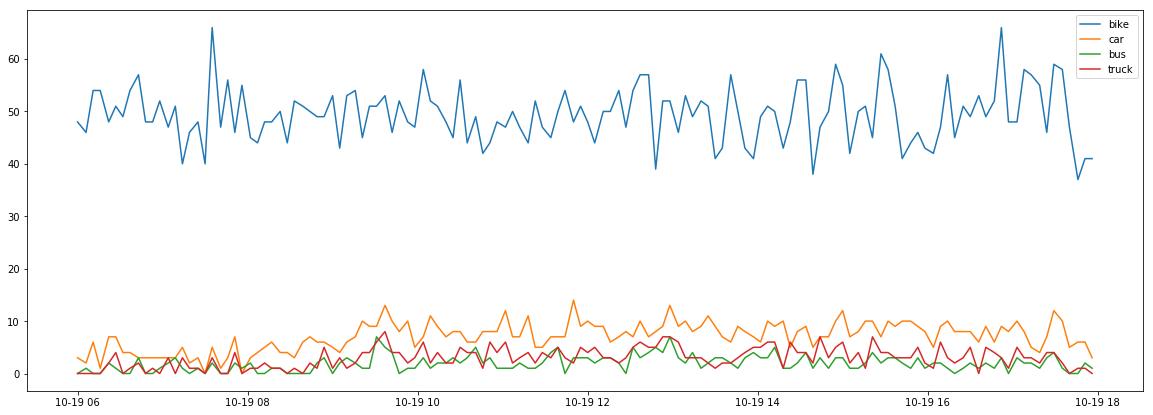

In [104]:
day_cond = 19
month_cond = 10
index_list = []
for index in preprocess['time'].astype('O').index:
    day = preprocess['time'].astype('O')[index]
    if day.day == day_cond and day.month == month_cond:
        index_list.append(index) 
        
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['motobike'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['car'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['bus'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['truck'].astype(int)[index_list])
plt.legend(['bike','car','bus','truck'])
plt.show()

In [105]:
preprocess.describe()

,motobike,car,bus,train,truck
count,2946.000000,2946.000000,2946.000000,2946.000000,2946.000000
mean,49.937542,6.802105,1.672777,0.023082,2.725390
std,7.098830,2.775813,1.451018,0.152434,1.935886
min,2.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,5.000000,1.000000,0.000000,1.000000
50%,50.000000,7.000000,1.000000,0.000000,3.000000
75%,54.000000,9.000000,3.000000,0.000000,4.000000
max,74.000000,17.000000,8.000000,2.000000,11.000000


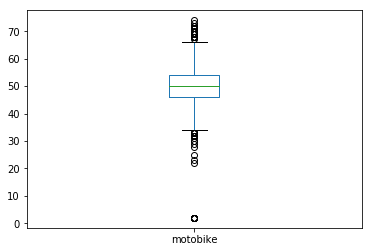

In [106]:
preprocess['motobike'].plot.box()

Text(0, 0.5, 'Number')

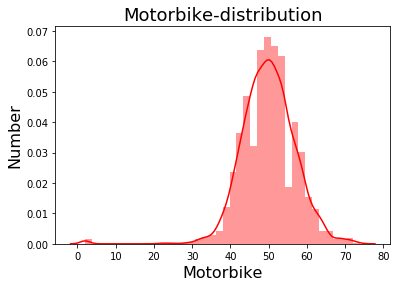

In [107]:
sns.distplot(preprocess['motobike'], kde=True, color='red', bins=40)
plt.title('Motorbike-distribution', fontsize=18)
plt.xlabel('Motorbike', fontsize=16)
plt.ylabel('Number', fontsize=16)

In [146]:
sns.distplot(preprocess['truck'], kde=True, color='black', bins=10)
plt.title('Truck-distribution', fontsize=18)
plt.xlabel('Quantity', fontsize=16)
plt.ylabel('Probability', fontsize=16)

KeyError: 'truck'

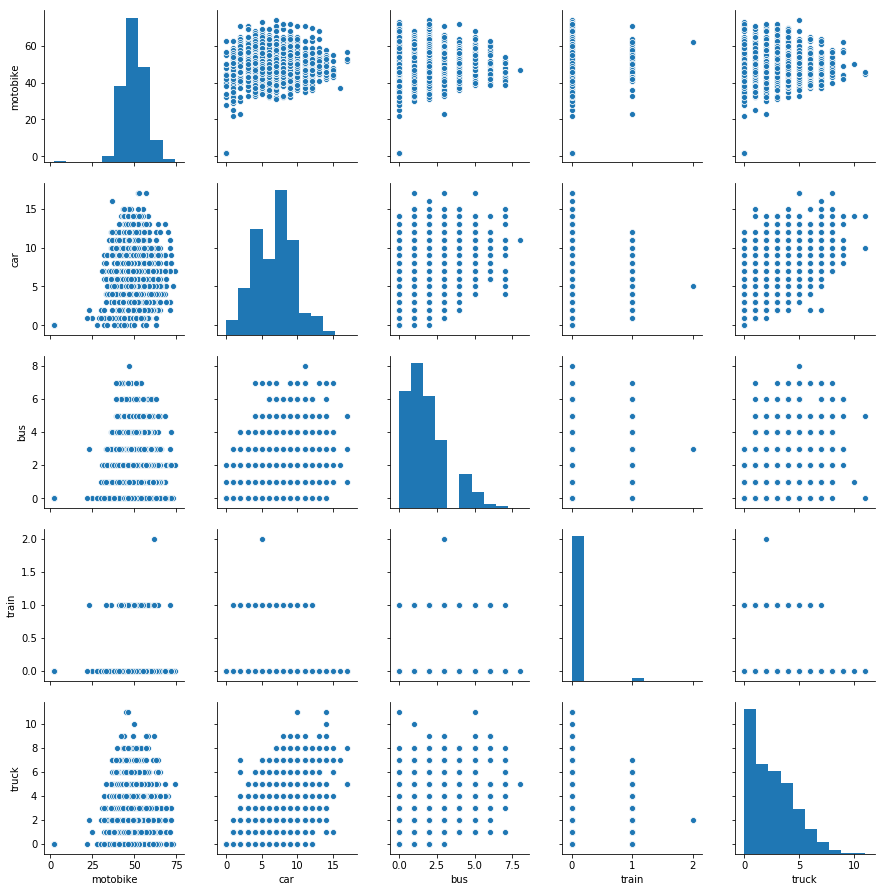

In [56]:
sns.pairplot(preprocess)

In [ ]:
datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')

In [ ]:
datetime_object

In [ ]:
dt = datetime.now()
tt = dt.timetuple()

In [ ]:
tt

In [ ]:
t1 = datetime.strptime(subStr[0], "%Y_%m_%d_%H_%M")

In [ ]:
t1

# Smoothing

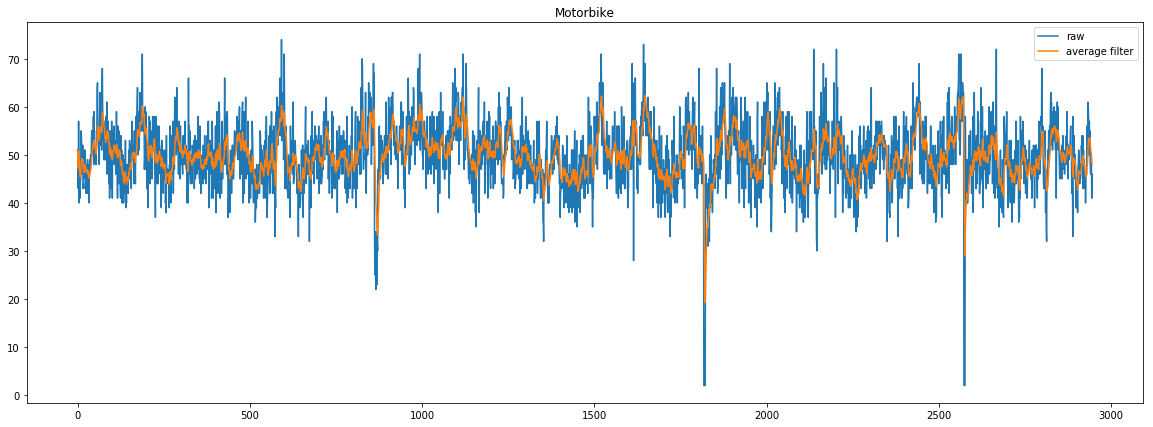

In [119]:
plt.figure(figsize=(20,7))
plt.plot(range(len(preprocess['motobike'])),preprocess['motobike'])
plt.plot(range(len(preprocess['motobike'])),preprocess['motobike'].ewm(span=10).mean())
plt.legend(['raw','average filter'])
plt.title('Motorbike')
plt.show()

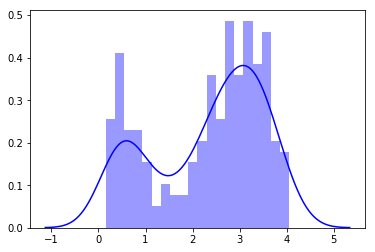

In [124]:
sns.distplot(preprocess['truck'][1500:1700].ewm(span=10).mean().values, kde=True, color='blue', bins=20)

# Kalman

In [57]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
            (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

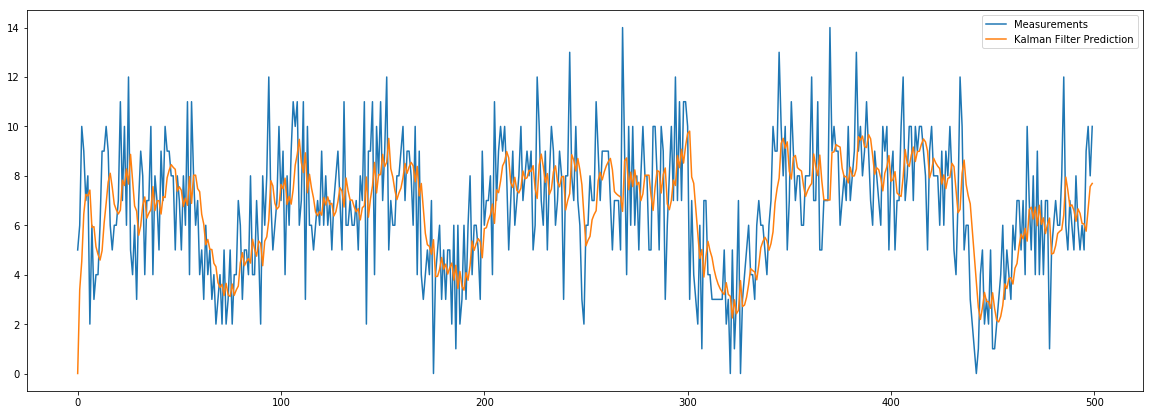

In [66]:
dt = 1/200
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

#x = np.linspace(-10, 10, 100)
#measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)

measurements = preprocess['car'].astype(int)[0:500].values

kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,7))
plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

Text(0, 0.5, 'Number')

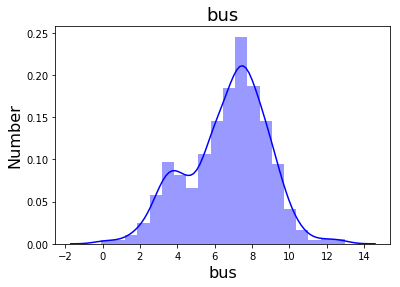

In [1080]:
sns.distplot(np.array(predictions)[1:-1], kde=True, color='blue', bins=20)
plt.title('bus', fontsize=18)
plt.xlabel('bus', fontsize=16)
plt.ylabel('Number', fontsize=16)

Text(0, 0.5, 'Number')

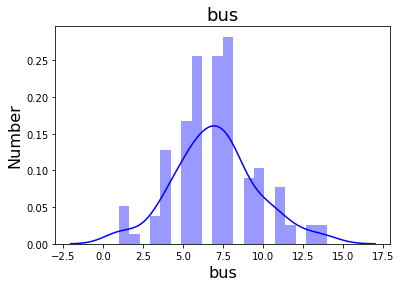

In [1070]:
sns.distplot(preprocess['car'][start:end], kde=True, color='blue', bins=20)
plt.title('bus', fontsize=18)
plt.xlabel('bus', fontsize=16)
plt.ylabel('Number', fontsize=16)

# Interpolate

In [162]:
test = np.array(preprocess['bus'][start:end])

In [165]:
preprocess.replace(0, np.nan, inplace=True)

In [307]:
inter = preprocess[['truck','time']].interpolate(method='slinear')

In [308]:
inter

,truck,time
788,NaN,2019-10-15 11:47:00
1127,NaN,2019-10-15 11:52:00
2104,1.000000,2019-10-15 11:58:00
142,1.333333,2019-10-15 12:01:00
1845,2.000000,2019-10-15 12:07:00
2374,3.000000,2019-10-15 12:12:00
1091,1.000000,2019-10-15 12:18:00
87,2.000000,2019-10-15 12:23:00
769,3.000000,2019-10-15 12:29:00
60,1.000000,2019-10-15 12:34:00


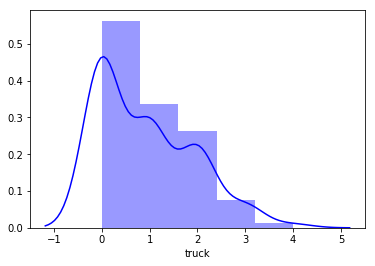

In [310]:
sns.distplot(preprocess[['truck','time']].interpolate(method='zero')['truck'][start:end], kde=True, color='blue', bins=5)

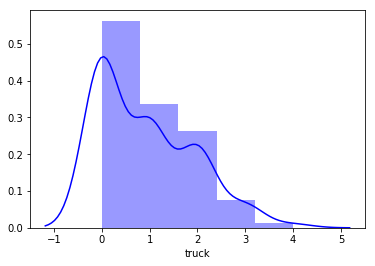

In [309]:
sns.distplot(inter['truck'][start:end], kde=True, color='blue', bins=5)

# From 1 camera predict another

In [90]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [143]:
preprocessed_df_list = []
for i,file in enumerate(glob.glob('./raw_fpn/*')):
    print(file)
    data = pd.read_csv(file)
    list_data = data.values.tolist()
    result_list = []
    for i,data in enumerate(list_data):
        data_temp = []
        filename = data[0]
        subStr = re.findall(r'_time_(.+?).jpg',filename)  
        t1 = datetime.strptime(subStr[0], "%Y_%m_%d_%H_%M")
        data.append(t1)
        #data_temp.append(filename)
        data_temp.append(t1)
        #traffic_status = int(data[1]) + int(data[3]) + int(data[6]) + int(data[7]) + int(data[8])
        data_temp.append(data[1])
        data_temp.append(data[3])
        data_temp.append(data[6])
        data_temp.append(data[7])
        data_temp.append(data[8])
        result_list.append(data_temp)
        name_camera = re.findall(r'camera_(.+?)_time_',filename)
    columns = ['time' , name_camera[0]+'_motobike',  name_camera[0]+'_car', name_camera[0]+'_bus', name_camera[0]+'_train', name_camera[0]+'_truck']
    preprocess = pd.DataFrame( result_list , columns = columns)
    preprocess = preprocess.sort_values(by='time',ascending=True)
    preprocessed_df_list.append(preprocess)

./raw_fpn/56df8416c062921100c143e4.csv
./raw_fpn/5a8256315058170011f6eac9.csv
./raw_fpn/56de42f611f398ec0c481290.csv
./raw_fpn/56df8381c062921100c143e2.csv
./raw_fpn/587c87e8b807da0011e33d45.csv
./raw_fpn/58abbf72bd82540010390ba4.csv
./raw_fpn/56df807bc062921100c143da.csv
./raw_fpn/56de42f611f398ec0c481287.csv
./raw_fpn/58ad69c4bd82540010390be7.csv
./raw_fpn/5a8279865058170011f6eaef.csv
./raw_fpn/587ee7d7b807da0011e33d55.csv
./raw_fpn/5a825b7d5058170011f6ead4.csv
./raw_fpn/585b284ac3f96200127dc500.csv
./raw_fpn/586e1f18f9fab7001111b0a5.csv
./raw_fpn/587ef5dfb807da0011e33d59.csv
./raw_fpn/56de42f611f398ec0c48128a.csv
./raw_fpn/56df8544c062921100c143e6.csv
./raw_fpn/56f8d743025e9511002786c5.csv
./raw_fpn/56de42f611f398ec0c481283.csv
./raw_fpn/58ad6214bd82540010390be2.csv
./raw_fpn/5ad0621c98d8fc001102e268.csv
./raw_fpn/56de42f611f398ec0c481298.csv
./raw_fpn/58af8a0bbd82540010390c25.csv
./raw_fpn/58746295b807da0011e33ccb.csv
./raw_fpn/5a10c79f02eb490011a0b0dd.csv
./raw_fpn/58746488b807da0

In [144]:
for i,df in enumerate(preprocessed_df_list):
    if i == 0:
        final_merge = df
    else: 
        final_merge = pd.merge(final_merge,df,on='time',how='outer')

In [145]:
final_merge_temp = final_merge.interpolate(method='linear')

In [146]:
final_merge_temp = final_merge_temp.sort_values(by='time',ascending=True)

In [147]:
from sklearn.preprocessing import MinMaxScaler
dataset = (final_merge_temp.drop(columns=['time'])).values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [148]:
final_merge_temp

,time,56df8416c062921100c143e4_motobike,56df8416c062921100c143e4_car,56df8416c062921100c143e4_bus,56df8416c062921100c143e4_train,56df8416c062921100c143e4_truck,5a8256315058170011f6eac9_motobike,5a8256315058170011f6eac9_car,5a8256315058170011f6eac9_bus,5a8256315058170011f6eac9_train,...,5a82628e5058170011f6eadb_motobike,5a82628e5058170011f6eadb_car,5a82628e5058170011f6eadb_bus,5a82628e5058170011f6eadb_train,5a82628e5058170011f6eadb_truck,56df833ac062921100c143e1_motobike,56df833ac062921100c143e1_car,56df833ac062921100c143e1_bus,56df833ac062921100c143e1_train,56df833ac062921100c143e1_truck
0,2019-10-15 11:47:00,33.0,2.0,0.0,0.0,0.0,16.0,16.0,3.0,0.0,...,14.000000,4.000000,1.0,0.0,2.000000,31.0,2.0,1.0,1.0,0.0
2949,2019-10-15 11:52:00,41.0,14.0,1.0,0.0,3.0,17.0,11.0,3.0,0.0,...,17.000000,7.000000,2.0,0.0,6.000000,47.0,10.0,2.0,0.0,2.0
1,2019-10-15 11:53:00,38.0,8.0,2.0,1.0,5.0,15.0,12.0,3.0,0.0,...,17.000000,3.000000,2.0,0.0,3.000000,36.5,2.0,1.0,0.5,0.5
2,2019-10-15 11:58:00,24.0,5.0,2.0,0.0,4.0,14.0,8.0,3.0,0.0,...,20.000000,2.000000,3.0,0.0,4.000000,42.0,2.0,1.0,0.0,1.0
3,2019-10-15 12:01:00,32.0,5.0,0.0,0.0,2.0,15.0,10.0,3.0,0.0,...,12.000000,2.000000,0.0,0.0,3.000000,32.0,3.0,2.0,1.0,3.0
3057,2019-10-15 12:06:00,41.0,14.0,1.0,0.0,3.0,20.0,13.0,2.0,0.0,...,15.333333,7.333333,6.0,0.0,7.666667,37.0,10.0,1.0,0.0,3.0
4,2019-10-15 12:07:00,28.0,2.0,0.0,1.0,0.0,20.0,6.0,2.0,1.0,...,10.000000,1.000000,1.0,1.0,5.000000,36.5,6.5,5.0,0.5,3.0
5,2019-10-15 12:12:00,43.0,9.0,0.0,0.0,3.0,16.0,7.0,3.0,1.0,...,13.000000,5.000000,0.0,0.0,3.000000,41.0,10.0,8.0,0.0,3.0
3058,2019-10-15 12:17:00,41.0,14.0,1.0,0.0,3.0,20.0,13.0,2.0,0.0,...,14.666667,6.666667,5.0,0.0,6.333333,45.0,8.0,2.0,0.0,4.0
6,2019-10-15 12:18:00,37.0,0.0,0.0,0.0,0.0,19.0,12.0,3.0,0.0,...,11.000000,4.000000,1.0,0.0,3.000000,41.0,7.5,5.0,0.0,2.5


name = '5b0b74280e517b00119fd7f9'
list_name_X = []
for clas in ['motobike','car','bus','train','truck']:
    list_name_X.append(name+'_'+clas)
name = '5b19d2f9af4ff60011d6ea4f'
list_name_Y = []
for clas in ['motobike','car','bus','train','truck']:
    list_name_Y.append(name+'_'+clas)

list_name_X = ['5b0b74280e517b00119fd7f9_motobike','5b0b74280e517b00119fd7f9_car']
list_name_Y = ['5b19d2f9af4ff60011d6ea4f_motobike','5b19d2f9af4ff60011d6ea4f_car']

final_merge_temp['5b0b74280e517b00119fd7f9_motobike'][0:1]

In [149]:
#camera_list_name = [ '5b0b74280e517b00119fd7f9', '5b19d34faf4ff60011d6ea52', '585b2baec3f96200127dc508']     
camera_list_name = [  '5b19d2f9af4ff60011d6ea4f' ,
                     '5b19d34faf4ff60011d6ea52', '585b2baec3f96200127dc508' , '585b284ac3f96200127dc500']  
list_name_X = []
for clas in ['motobike','car','bus','train','truck']:
    for camera in camera_list_name:
        list_name_X.append(camera+'_'+clas)
camera_list_name = ['5b0b74280e517b00119fd7f9']
list_name_Y = []
for clas in ['motobike','car','bus','train','truck']:
    for camera in camera_list_name:
        list_name_Y.append(camera+'_'+clas)

In [150]:
trainX = final_merge_temp[list_name_X].ewm(span=10).mean()
scaler = MinMaxScaler(feature_range=(0, 1))
trainX = scaler.fit_transform(trainX)

trainY = final_merge_temp[list_name_Y].ewm(span=10).mean()
scaler = MinMaxScaler(feature_range=(0, 1))
trainY = scaler.fit_transform(trainY)

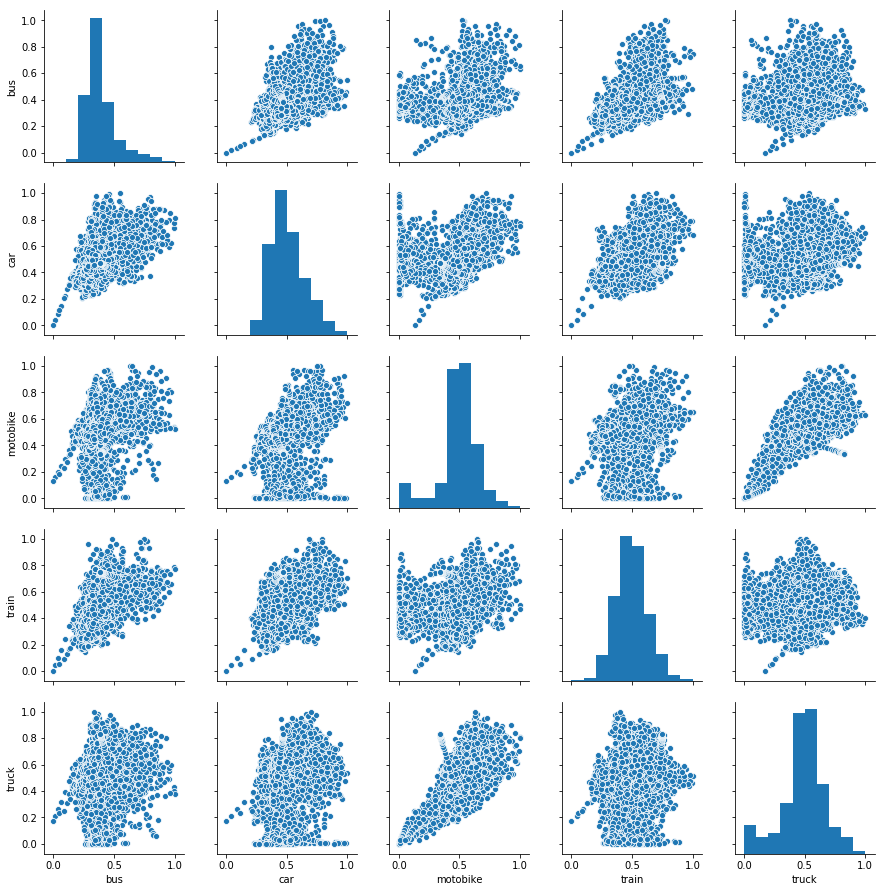

In [151]:
dataset = pd.DataFrame({'motobike': trainX[:, 0], 'car': trainX[:, 1], 'bus': trainX[:, 2], 'train': trainX[:, 3], 'truck': trainX[:, 4]})
sns.pairplot(dataset)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

trainX, trainY = create_dataset(trainX)

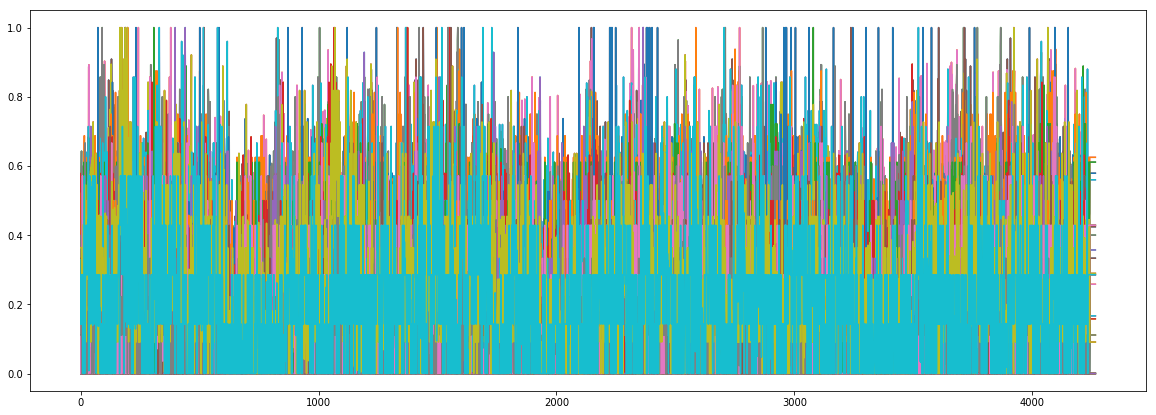

In [101]:
plt.figure(figsize=(20,7))
plt.plot(range(len(trainX)),scaler.fit_transform(final_merge_temp[list_name_X].values))
plt.plot(range(len(trainX)),trainX)

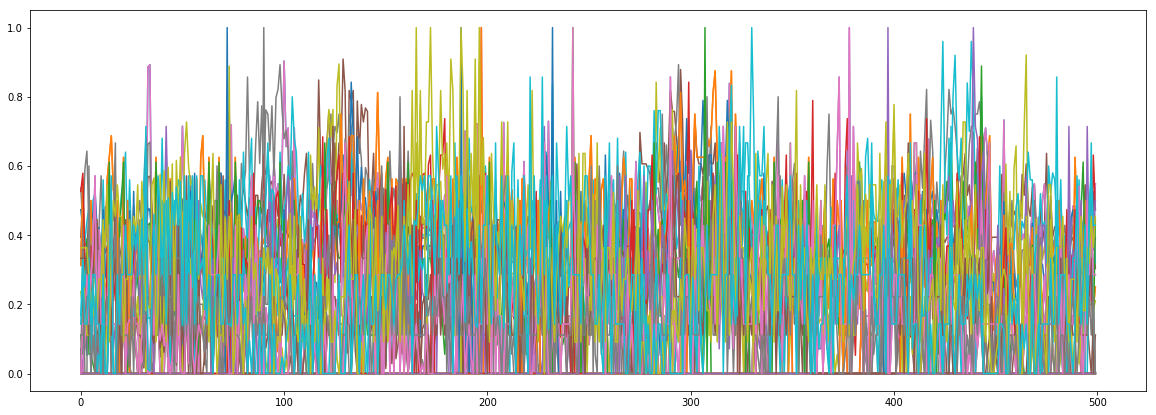

In [102]:
plt.figure(figsize=(20,7))
#plt.plot(range(len(trainY)),scaler.fit_transform(final_merge_temp[list_name_Y].values))
plt.plot(range(len(trainY[0:500])),trainY[0:500])
plt.plot(range(len(trainX[0:500])),trainX[0:500])

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

temp = np.random.randint(2, size=129)

list_index = []
for i in temp:
    if i == 0 :
        for j in range(5):
            list_index.append(0)
    else :
        for j in range(5):
            list_index.append(1)
list_index = np.array(list_index)

trainX = train[:,list(np.where(list_index==0)[0])]
trainY = train[:,list(np.where(list_index==1)[0])]
testX = test[:,list(np.where(list_index==0)[0])]
testY = test[:,list(np.where(list_index==1)[0])]

number_camera = 100
trainX = train[:,0:5*number_camera]
trainY = train[:,5*number_camera:-1]
testX = test[:,0:5*number_camera]
testY = test[:,5*number_camera:-1]

In [152]:
train_size = int(len(trainX) * 0.67)
#test_size = len(trainY) - train_size
trainY, testY = trainY[0:train_size,:], trainY[train_size:len(trainY),:]
trainX, testX = trainX[0:train_size,:], trainX[train_size:len(trainX),:]
print(len(trainX), len(testX))

2858 1409


trainX.shape

In [153]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1] ,1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

In [154]:
testY = testY[:,0].reshape(-1,1)
trainY = trainY[:,0].reshape(-1,1)

trainY = trainY.reshape(-1,1)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1], 1)))
model.add(Dense(trainY.shape[1]))
model.summary()

In [155]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], 1)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(trainY.shape[1]))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 20, 100)           40800     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [156]:
from keras.optimizers import Adam 
adam = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [157]:
model.compile(loss='mse', optimizer=adam)
model.fit(trainX, trainY ,epochs=10000000, batch_size=512, verbose=2 ,validation_data = (testX,testY))

Train on 2858 samples, validate on 1409 samples
Epoch 1/10000000
 - 1s - loss: 0.3403 - val_loss: 0.3268
Epoch 2/10000000
 - 0s - loss: 0.3389 - val_loss: 0.3255
Epoch 3/10000000
 - 0s - loss: 0.3375 - val_loss: 0.3242
Epoch 4/10000000
 - 0s - loss: 0.3362 - val_loss: 0.3229
Epoch 5/10000000
 - 0s - loss: 0.3349 - val_loss: 0.3216
Epoch 6/10000000
 - 0s - loss: 0.3335 - val_loss: 0.3203
Epoch 7/10000000
 - 0s - loss: 0.3322 - val_loss: 0.3190
Epoch 8/10000000
 - 0s - loss: 0.3309 - val_loss: 0.3178
Epoch 9/10000000
 - 0s - loss: 0.3297 - val_loss: 0.3165
Epoch 10/10000000
 - 0s - loss: 0.3284 - val_loss: 0.3153
Epoch 11/10000000
 - 0s - loss: 0.3271 - val_loss: 0.3141
Epoch 12/10000000
 - 0s - loss: 0.3259 - val_loss: 0.3129
Epoch 13/10000000
 - 0s - loss: 0.3246 - val_loss: 0.3116
Epoch 14/10000000
 - 0s - loss: 0.3234 - val_loss: 0.3104
Epoch 15/10000000
 - 0s - loss: 0.3221 - val_loss: 0.3092
Epoch 16/10000000
 - 0s - loss: 0.3209 - val_loss: 0.3080
Epoch 17/10000000
 - 0s - loss: 0

Epoch 141/10000000
 - 0s - loss: 0.0142 - val_loss: 0.0079
Epoch 142/10000000
 - 0s - loss: 0.0142 - val_loss: 0.0079
Epoch 143/10000000
 - 0s - loss: 0.0141 - val_loss: 0.0079
Epoch 144/10000000
 - 0s - loss: 0.0141 - val_loss: 0.0079
Epoch 145/10000000
 - 0s - loss: 0.0141 - val_loss: 0.0079
Epoch 146/10000000
 - 0s - loss: 0.0141 - val_loss: 0.0079
Epoch 147/10000000
 - 0s - loss: 0.0141 - val_loss: 0.0079
Epoch 148/10000000
 - 0s - loss: 0.0141 - val_loss: 0.0079
Epoch 149/10000000
 - 0s - loss: 0.0141 - val_loss: 0.0079
Epoch 150/10000000
 - 0s - loss: 0.0140 - val_loss: 0.0079
Epoch 151/10000000
 - 0s - loss: 0.0140 - val_loss: 0.0078
Epoch 152/10000000
 - 0s - loss: 0.0140 - val_loss: 0.0078
Epoch 153/10000000
 - 0s - loss: 0.0140 - val_loss: 0.0078
Epoch 154/10000000
 - 0s - loss: 0.0140 - val_loss: 0.0078
Epoch 155/10000000
 - 0s - loss: 0.0140 - val_loss: 0.0078
Epoch 156/10000000
 - 0s - loss: 0.0140 - val_loss: 0.0078
Epoch 157/10000000
 - 0s - loss: 0.0139 - val_loss: 0.00

Epoch 280/10000000
 - 0s - loss: 0.0116 - val_loss: 0.0066
Epoch 281/10000000
 - 0s - loss: 0.0116 - val_loss: 0.0066
Epoch 282/10000000
 - 0s - loss: 0.0116 - val_loss: 0.0065
Epoch 283/10000000
 - 0s - loss: 0.0116 - val_loss: 0.0065
Epoch 284/10000000
 - 0s - loss: 0.0116 - val_loss: 0.0065
Epoch 285/10000000
 - 0s - loss: 0.0115 - val_loss: 0.0065
Epoch 286/10000000
 - 0s - loss: 0.0115 - val_loss: 0.0065
Epoch 287/10000000
 - 0s - loss: 0.0115 - val_loss: 0.0065
Epoch 288/10000000
 - 0s - loss: 0.0115 - val_loss: 0.0065
Epoch 289/10000000
 - 0s - loss: 0.0115 - val_loss: 0.0065
Epoch 290/10000000
 - 0s - loss: 0.0114 - val_loss: 0.0065
Epoch 291/10000000
 - 0s - loss: 0.0114 - val_loss: 0.0064
Epoch 292/10000000
 - 0s - loss: 0.0114 - val_loss: 0.0064
Epoch 293/10000000
 - 0s - loss: 0.0114 - val_loss: 0.0064
Epoch 294/10000000
 - 0s - loss: 0.0113 - val_loss: 0.0064
Epoch 295/10000000
 - 0s - loss: 0.0113 - val_loss: 0.0064
Epoch 296/10000000
 - 0s - loss: 0.0113 - val_loss: 0.00

Epoch 419/10000000
 - 0s - loss: 0.0089 - val_loss: 0.0054
Epoch 420/10000000
 - 0s - loss: 0.0089 - val_loss: 0.0054
Epoch 421/10000000
 - 0s - loss: 0.0089 - val_loss: 0.0054
Epoch 422/10000000
 - 0s - loss: 0.0089 - val_loss: 0.0054
Epoch 423/10000000
 - 0s - loss: 0.0088 - val_loss: 0.0054
Epoch 424/10000000
 - 0s - loss: 0.0088 - val_loss: 0.0054
Epoch 425/10000000
 - 0s - loss: 0.0088 - val_loss: 0.0054
Epoch 426/10000000
 - 0s - loss: 0.0088 - val_loss: 0.0054
Epoch 427/10000000
 - 0s - loss: 0.0088 - val_loss: 0.0053
Epoch 428/10000000
 - 0s - loss: 0.0088 - val_loss: 0.0053
Epoch 429/10000000
 - 0s - loss: 0.0087 - val_loss: 0.0053
Epoch 430/10000000
 - 0s - loss: 0.0087 - val_loss: 0.0053
Epoch 431/10000000
 - 0s - loss: 0.0087 - val_loss: 0.0053
Epoch 432/10000000
 - 0s - loss: 0.0087 - val_loss: 0.0053
Epoch 433/10000000
 - 0s - loss: 0.0087 - val_loss: 0.0054
Epoch 434/10000000
 - 0s - loss: 0.0087 - val_loss: 0.0054
Epoch 435/10000000
 - 0s - loss: 0.0086 - val_loss: 0.00

Epoch 558/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0053
Epoch 559/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0054
Epoch 560/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0054
Epoch 561/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0053
Epoch 562/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0053
Epoch 563/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0053
Epoch 564/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0054
Epoch 565/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0054
Epoch 566/10000000
 - 0s - loss: 0.0075 - val_loss: 0.0053
Epoch 567/10000000
 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 568/10000000
 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 569/10000000
 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 570/10000000
 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 571/10000000
 - 0s - loss: 0.0074 - val_loss: 0.0053
Epoch 572/10000000
 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 573/10000000
 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 574/10000000
 - 0s - loss: 0.0074 - val_loss: 0.00

KeyboardInterrupt: 

In [158]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# RMSE
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.09 RMSE
Test Score: 0.07 RMSE


model.predict(trainX[1:2,:,:])

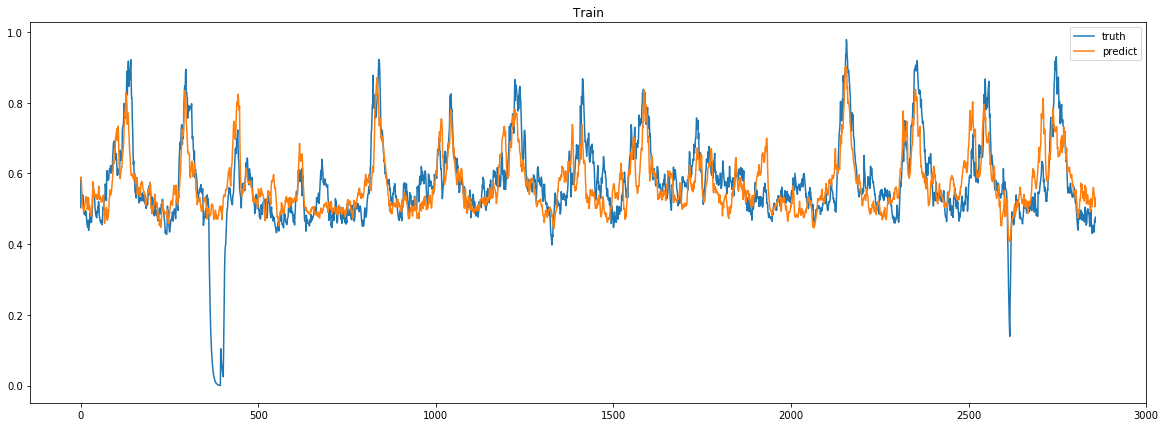

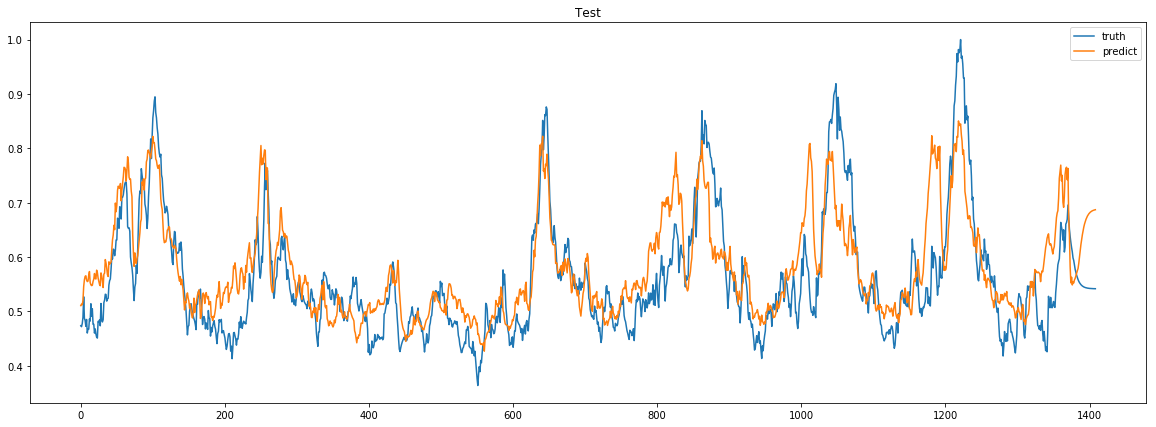

In [159]:
classes = [0]
fig, ax = plt.subplots(figsize=(20,7))
ax.plot( trainY[:,classes])
ax.plot( trainPredict[:,classes])
plt.legend(['truth','predict'])
plt.title('Train')
plt.show()
fig, ax = plt.subplots(figsize=(20,7))
ax.plot( testY[:,classes])
ax.plot( testPredict[:,classes])
plt.legend(['truth','predict'])
plt.title('Test')
plt.show()

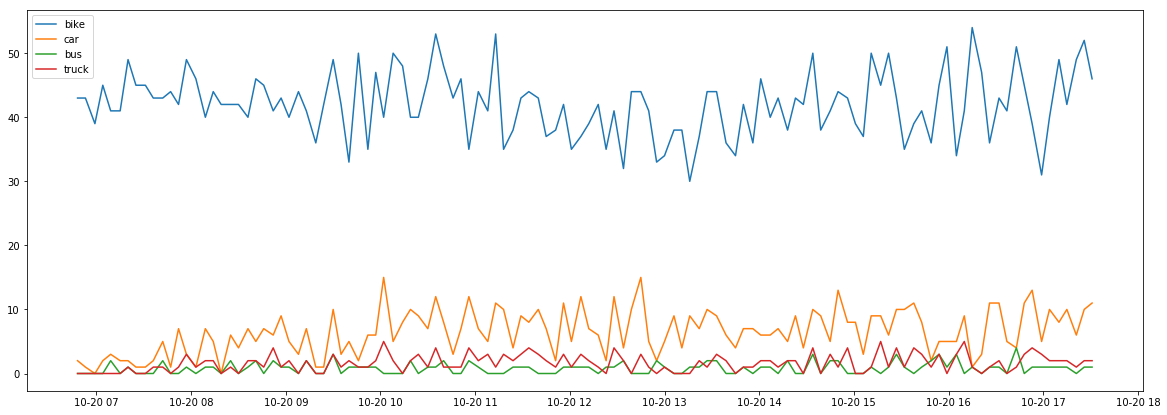

In [496]:
start = 450
end = 570
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(preprocess['time'].astype('O')[start:end], preprocess['motobike'].astype(int)[start:end])
ax.plot(preprocess['time'].astype('O')[start:end], preprocess['car'].astype(int)[start:end])
ax.plot(preprocess['time'].astype('O')[start:end], preprocess['bus'].astype(int)[start:end])
ax.plot(preprocess['time'].astype('O')[start:end], preprocess['truck'].astype(int)[start:end])
plt.legend(['bike','car','bus','truck'])
plt.show()

In [497]:
pd.merge(preprocessed_df_list[0],preprocessed_df_list[1],on='time',how='outer')

,filename_x,motobike_x,car_x,bus_x,train_x,truck_x,time,filename_y,motobike_y,car_y,bus_y,train_y,truck_y
0,/home/duyle/Desktop/Khang/dataset/traffic/data...,33.0,2.0,0.0,0.0,0.0,2019-10-15 11:47:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,16.0,16.0,3.0,0.0,3.0
1,/home/duyle/Desktop/Khang/dataset/traffic/data...,38.0,8.0,2.0,1.0,5.0,2019-10-15 11:53:00,NaN,NaN,NaN,NaN,NaN,NaN
2,/home/duyle/Desktop/Khang/dataset/traffic/data...,24.0,5.0,2.0,0.0,4.0,2019-10-15 11:58:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,14.0,8.0,3.0,0.0,3.0
3,/home/duyle/Desktop/Khang/dataset/traffic/data...,32.0,5.0,0.0,0.0,2.0,2019-10-15 12:01:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,15.0,10.0,3.0,0.0,5.0
4,/home/duyle/Desktop/Khang/dataset/traffic/data...,28.0,2.0,0.0,1.0,0.0,2019-10-15 12:07:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,20.0,6.0,2.0,1.0,1.0
5,/home/duyle/Desktop/Khang/dataset/traffic/data...,43.0,9.0,0.0,0.0,3.0,2019-10-15 12:12:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,16.0,7.0,3.0,1.0,1.0
6,/home/duyle/Desktop/Khang/dataset/traffic/data...,37.0,0.0,0.0,0.0,0.0,2019-10-15 12:18:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,19.0,12.0,3.0,0.0,1.0
7,/home/duyle/Desktop/Khang/dataset/traffic/data...,41.0,7.0,0.0,0.0,1.0,2019-10-15 12:23:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,17.0,13.0,1.0,0.0,2.0
8,/home/duyle/Desktop/Khang/dataset/traffic/data...,37.0,10.0,0.0,0.0,1.0,2019-10-15 12:29:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,17.0,11.0,4.0,0.0,4.0
9,/home/duyle/Desktop/Khang/dataset/traffic/data...,34.0,0.0,0.0,0.0,1.0,2019-10-15 12:34:00,/home/duyle/Desktop/Khang/dataset/traffic/data...,14.0,5.0,3.0,0.0,0.0


In [498]:
for i,df in enumerate(preprocessed_df_list):
    if i == 0:
        final_merge = df
    else: 
        final_merge = pd.merge(final_merge,df,on='time',how='outer')

KeyboardInterrupt: 

In [ ]:
final_merge

final_merge_temp = final_merge.interpolate(method='linear')

# Combine merge

In [1]:
preprocessed_df_list = []
for i,file in enumerate(glob.glob('./raw_fpn/*')):
    print(file)
    data = pd.read_csv(file)
    list_data = data.values.tolist()
    result_list = []
    for i,data in enumerate(list_data):
        data_temp = []
        filename = data[0]
        subStr = re.findall(r'_time_(.+?).jpg',filename)  
        t1 = datetime.strptime(subStr[0], "%Y_%m_%d_%H_%M")
        data.append(t1)
        #data_temp.append(filename)
        data_temp.append(t1)
        traffic_status = int(data[1]) + int(data[3])*2 + int(data[6])*6 + int(data[7])*4 + int(data[8])*4
        data_temp.append(traffic_status)
        result_list.append(data_temp)
        name_camera = re.findall(r'camera_(.+?)_time_',filename)
    columns = ['time' , name_camera[0]]
    preprocess = pd.DataFrame( result_list , columns = columns)
    preprocess = preprocess.sort_values(by='time',ascending=True)
    preprocessed_df_list.append(preprocess)

NameError: name 'glob' is not defined

In [2]:
for i,df in enumerate(preprocessed_df_list):
    if i == 0:
        final_merge = df
    else: 
        final_merge = pd.merge(final_merge,df,on='time',how='outer')

In [597]:
final_merge_temp = final_merge.interpolate(method='linear')

In [598]:
final_merge_temp

,time,56df8416c062921100c143e4,5a8256315058170011f6eac9,56de42f611f398ec0c481290,56df8381c062921100c143e2,587c87e8b807da0011e33d45,58abbf72bd82540010390ba4,56df807bc062921100c143da,56de42f611f398ec0c481287,58ad69c4bd82540010390be7,...,56de42f611f398ec0c481297,56de42f611f398ec0c48129b,56de42f611f398ec0c48128b,56de42f611f398ec0c481289,56de42f611f398ec0c481294,5a824b6c5058170011f6eaab,58746371b807da0011e33cd1,586e28a0f9fab7001111b0b3,5a82628e5058170011f6eadb,56df833ac062921100c143e1
0,2019-10-15 11:47:00,37.0,78.0,36.00,64.000,55.0,153.0,87.0,40.000000,60.0,...,59.00,25.0,61.000000,50.000000,42.000000,20.0,57.0,28.00,36.0,45.000
1,2019-10-15 11:53:00,90.0,69.0,41.50,80.500,52.0,146.0,101.0,49.000000,100.0,...,39.00,26.0,43.000000,63.000000,45.000000,21.5,47.5,26.50,47.0,50.500
2,2019-10-15 11:58:00,62.0,60.0,47.00,97.000,49.0,139.0,100.5,58.000000,60.0,...,19.00,27.0,25.000000,76.000000,48.000000,23.0,38.0,25.00,58.0,56.000
3,2019-10-15 12:01:00,50.0,73.0,38.00,67.000,74.0,118.0,100.0,29.000000,80.0,...,47.00,29.0,32.000000,34.000000,47.000000,23.0,65.0,11.00,28.0,66.000
4,2019-10-15 12:07:00,36.0,52.0,35.50,65.000,55.0,133.0,78.0,26.000000,39.0,...,62.50,28.0,43.000000,51.500000,33.500000,44.0,25.0,55.00,42.0,93.500
5,2019-10-15 12:12:00,73.0,56.0,33.00,63.000,54.0,128.0,64.0,39.000000,93.0,...,78.00,41.0,54.000000,69.000000,20.000000,29.0,34.0,25.00,35.0,121.000
6,2019-10-15 12:18:00,37.0,65.0,32.50,56.500,57.0,117.0,80.0,39.000000,61.0,...,53.50,17.0,50.000000,53.500000,31.500000,35.0,17.0,53.00,37.0,96.000
7,2019-10-15 12:23:00,59.0,57.0,32.00,50.000,58.0,149.0,78.0,39.000000,87.0,...,29.00,44.0,46.000000,38.000000,43.000000,41.0,19.0,45.00,106.0,71.000
8,2019-10-15 12:29:00,61.0,79.0,77.00,56.000,44.0,155.0,61.0,33.000000,61.0,...,22.00,33.0,50.000000,31.500000,45.500000,10.0,59.0,46.00,32.0,54.000
9,2019-10-15 12:34:00,38.0,42.0,36.00,76.000,51.0,125.0,91.0,31.000000,71.0,...,56.00,19.0,35.000000,25.000000,48.000000,13.0,25.0,24.00,34.0,52.000


In [599]:
final_merge_temp = final_merge_temp.sort_values(by='time',ascending=True)

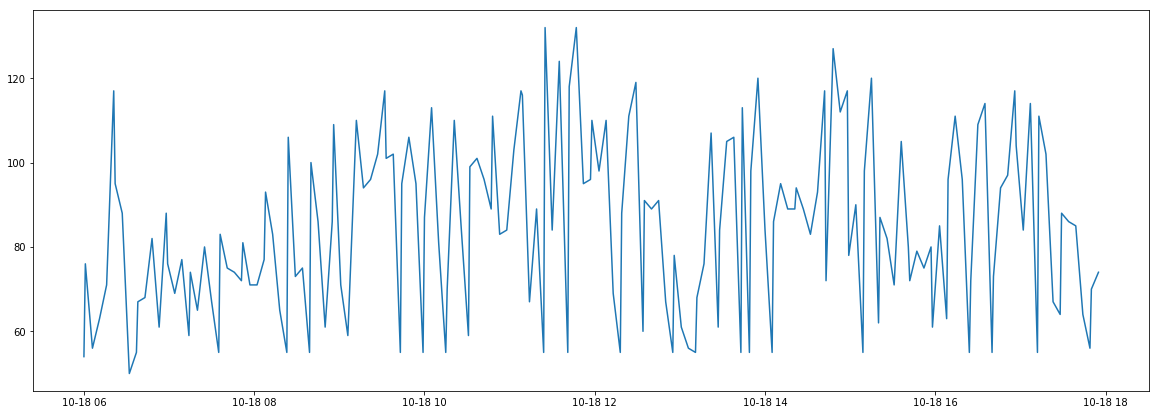

In [607]:
day_cond = 18
month_cond = 10
index_list = []
for index in final_merge_temp['time'].astype('O').index:
    day = final_merge_temp['time'].astype('O')[index]
    if day.day == day_cond and day.month == month_cond:
        index_list.append(index) 
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(final_merge_temp['time'].astype('O')[index_list], final_merge_temp['587476e3b807da0011e33cee'].astype(int)[index_list])
plt.show()

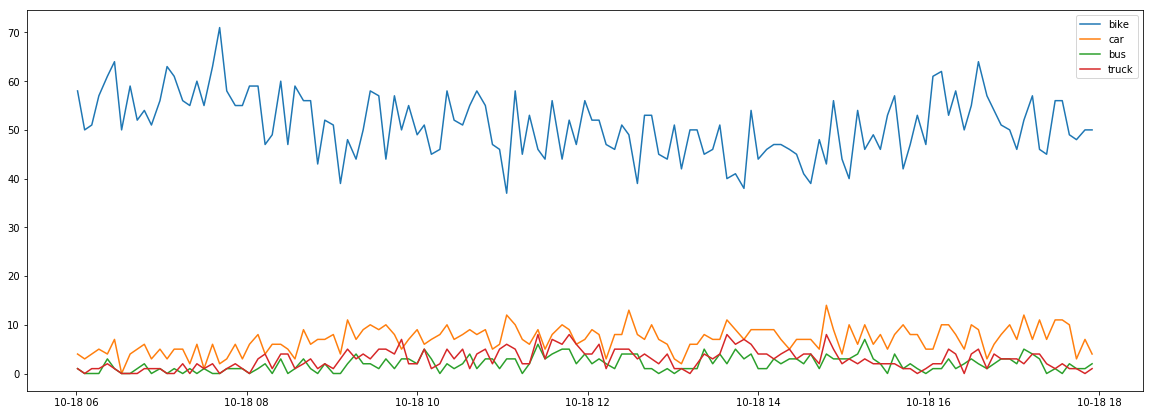

In [608]:
day_cond = 18
month_cond = 10
index_list = []
for index in preprocess['time'].astype('O').index:
    day = preprocess['time'].astype('O')[index]
    if day.day == day_cond and day.month == month_cond:
        index_list.append(index) 
        
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['motobike'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['car'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['bus'].astype(int)[index_list])
ax.plot(preprocess['time'].astype('O')[index_list], preprocess['truck'].astype(int)[index_list])
plt.legend(['bike','car','bus','truck'])
plt.show()

# Time series predict next 30 minutes

In [1]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model


Using TensorFlow backend.


In [2]:
preprocessed_df_list = []
for i,file in enumerate(glob.glob('./raw_fpn/*')):
    print(file)
    data = pd.read_csv(file)
    list_data = data.values.tolist()
    result_list = []
    for i,data in enumerate(list_data):
        data_temp = []
        filename = data[0]
        subStr = re.findall(r'_time_(.+?).jpg',filename)  
        t1 = datetime.strptime(subStr[0], "%Y_%m_%d_%H_%M")
        data.append(t1)
        #data_temp.append(filename)
        data_temp.append(t1)
        #traffic_status = int(data[1]) + int(data[3]) + int(data[6]) + int(data[7]) + int(data[8])
        data_temp.append(data[1])
        data_temp.append(data[3])
        data_temp.append(data[6])
        data_temp.append(data[7])
        data_temp.append(data[8])
        result_list.append(data_temp)
        name_camera = re.findall(r'camera_(.+?)_time_',filename)
    columns = ['time' , name_camera[0]+'_motobike',  name_camera[0]+'_car', name_camera[0]+'_bus', name_camera[0]+'_train', name_camera[0]+'_truck']
    preprocess = pd.DataFrame( result_list , columns = columns)
    preprocess = preprocess.sort_values(by='time',ascending=True)
    preprocessed_df_list.append(preprocess)

./raw_fpn/56df8416c062921100c143e4.csv
./raw_fpn/5a8256315058170011f6eac9.csv
./raw_fpn/56de42f611f398ec0c481290.csv
./raw_fpn/56df8381c062921100c143e2.csv
./raw_fpn/587c87e8b807da0011e33d45.csv
./raw_fpn/58abbf72bd82540010390ba4.csv
./raw_fpn/56df807bc062921100c143da.csv
./raw_fpn/56de42f611f398ec0c481287.csv
./raw_fpn/58ad69c4bd82540010390be7.csv
./raw_fpn/5a8279865058170011f6eaef.csv
./raw_fpn/587ee7d7b807da0011e33d55.csv
./raw_fpn/5a825b7d5058170011f6ead4.csv
./raw_fpn/585b284ac3f96200127dc500.csv
./raw_fpn/586e1f18f9fab7001111b0a5.csv
./raw_fpn/587ef5dfb807da0011e33d59.csv
./raw_fpn/56de42f611f398ec0c48128a.csv
./raw_fpn/56df8544c062921100c143e6.csv
./raw_fpn/56f8d743025e9511002786c5.csv
./raw_fpn/56de42f611f398ec0c481283.csv
./raw_fpn/58ad6214bd82540010390be2.csv
./raw_fpn/5ad0621c98d8fc001102e268.csv
./raw_fpn/56de42f611f398ec0c481298.csv
./raw_fpn/58af8a0bbd82540010390c25.csv
./raw_fpn/58746295b807da0011e33ccb.csv
./raw_fpn/5a10c79f02eb490011a0b0dd.csv
./raw_fpn/58746488b807da0

In [3]:
for i,df in enumerate(preprocessed_df_list):
    if i == 0:
        final_merge = df
    else: 
        final_merge = pd.merge(final_merge,df,on='time',how='outer')

In [4]:
final_merge_temp = final_merge.interpolate(method='linear')

In [5]:
final_merge_temp = final_merge_temp.sort_values(by='time',ascending=True)

dataset = (final_merge_temp.drop(columns=['time'])).values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

final_merge_temp['5b6c155aca0577001163fe36_motobike'][0:1]

camera_list_name = ['58ad6214bd82540010390be2','586e1f18f9fab7001111b0a5','586e1d4ef9fab7001111b0a2',
 '59414c883dcfc400106f260b','56df807bc062921100c143da',
 '5875cb72b807da0011e33d0c', '56df857fc062921100c143e7','56df85bdc062921100c143e8',
 '587c8d97b807da0011e33d49','56f11ac33ac17b11001c504c']

In [6]:
camera_list_name = [ '5b0b74280e517b00119fd7f9', '5b19d2f9af4ff60011d6ea4f' ,
                     '5b19d34faf4ff60011d6ea52', '585b2baec3f96200127dc508' , '585b284ac3f96200127dc500']     

In [7]:
#camera_list_name = ['5b0b74280e517b00119fd7f9']
#camera_list_name = ['587c8183b807da0011e33d3f']
list_name_X = []
for clas in ['motobike','car','bus','truck']:
    for camera in camera_list_name:
        list_name_X.append(camera+'_'+clas)
# camera_list_name = ['5b19d2f9af4ff60011d6ea4f']
# list_name_Y = []
# for clas in ['motobike','car','bus','train','truck']:
#     for camera in camera_list_name:
#         list_name_Y.append(camera+'_'+clas)

In [32]:
trainX = final_merge_temp[list_name_X].ewm(span=1).mean()
scaler_train = MinMaxScaler(feature_range=(0, 1))
trainX = scaler_train.fit_transform(trainX)

# trainY = final_merge_temp['5b0b74280e517b00119fd7f9_motobike'].ewm(span=10).mean()
# scaler_test = MinMaxScaler(feature_range=(0, 1))
# trainY = scaler_test.fit_transform(trainY)

plt.figure(figsize=(20,7))
a = final_merge_temp[list_name_X].ewm(span=1).mean().values[:,0].reshape(-1,1)[0:100,:]
b = final_merge_temp[list_name_X].ewm(span=5).mean().values[:,0].reshape(-1,1)[0:100,:]
plt.plot(range(len(a)),a)
plt.plot(range(len(b)),b)

dataset = pd.DataFrame({'motobike': trainX[:, 0], 'car': trainX[:, 1], 'bus': trainX[:, 2], 'train': trainX[:, 3], 'truck': trainX[:, 4]})
sns.pairplot(dataset)

#dataset = final_merge_temp.drop(['time'], axis=1).ewm(span=20).mean()
dataset = final_merge_temp['5b0b74280e517b00119fd7f9_motobike'].ewm(span=20).mean()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [33]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, next_time = 10 ):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-next_time):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back + next_time, :])
    return numpy.array(dataX), numpy.array(dataY)

In [34]:
trainX , trainY = create_dataset(trainX)

trainX[21,0] -  trainY[0]

def fft_FE(array):
    hann = np.hanning(len(array))
    Y = np.fft.fft(hann*array)
    return Y

indexa = 1
indexb = 6
a = np.abs(fft_FE(trainY[:,indexa]))
b = np.abs(fft_FE(trainY[:,indexb]))
plt.show()
fig, ax = plt.subplots(figsize=(20,7))
ax.plot( trainY[:,indexa])
ax.plot( trainY[:,indexb])
plt.show()
print(np.mean(( a/np.max(a) - b/np.max(b) )**2))

In [35]:
train_size = int(len(trainX) * 0.67)
#test_size = len(trainY) - train_size
trainY, testY = trainY[0:train_size,:], trainY[train_size:len(trainY),:]
trainX, testX = trainX[0:train_size,:], trainX[train_size:len(trainX),:]
print(len(trainX), len(testX))

2850 1405


In [36]:
trainY = trainY[:,0].reshape(-1,1)
testY = testY[:,0].reshape(-1,1)

trainY = np.where(trainY>0.5 , 1, 0)
testY  = np.where(testY>0.5 , 1, 0)

In [37]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2] , 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[2], 1))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(trainX.shape[1], 1)))
model.add(Dense(trainY.shape[1]))
model.summary()

In [38]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(trainY.shape[1]))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 100)           40800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [39]:
from keras.optimizers import Adam 
adam = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [175]:
model.compile(loss='mse', optimizer=adam)
model.fit(trainX, trainY ,epochs=10000000, batch_size=512, verbose=2 ,validation_data = (testX,testY))

Train on 2850 samples, validate on 1405 samples
Epoch 1/10000000
 - 1s - loss: 0.3678 - val_loss: 0.3528
Epoch 2/10000000
 - 0s - loss: 0.3665 - val_loss: 0.3516
Epoch 3/10000000
 - 0s - loss: 0.3653 - val_loss: 0.3503
Epoch 4/10000000
 - 0s - loss: 0.3640 - val_loss: 0.3491
Epoch 5/10000000
 - 0s - loss: 0.3628 - val_loss: 0.3479
Epoch 6/10000000
 - 0s - loss: 0.3615 - val_loss: 0.3467
Epoch 7/10000000
 - 0s - loss: 0.3602 - val_loss: 0.3454
Epoch 8/10000000
 - 0s - loss: 0.3589 - val_loss: 0.3441
Epoch 9/10000000
 - 0s - loss: 0.3576 - val_loss: 0.3428
Epoch 10/10000000
 - 0s - loss: 0.3563 - val_loss: 0.3415
Epoch 11/10000000
 - 0s - loss: 0.3549 - val_loss: 0.3402
Epoch 12/10000000
 - 0s - loss: 0.3536 - val_loss: 0.3388
Epoch 13/10000000
 - 0s - loss: 0.3522 - val_loss: 0.3375
Epoch 14/10000000
 - 0s - loss: 0.3508 - val_loss: 0.3361
Epoch 15/10000000
 - 0s - loss: 0.3493 - val_loss: 0.3346
Epoch 16/10000000
 - 0s - loss: 0.3478 - val_loss: 0.3331
Epoch 17/10000000
 - 0s - loss: 0

Epoch 141/10000000
 - 0s - loss: 0.0126 - val_loss: 0.0087
Epoch 142/10000000
 - 0s - loss: 0.0126 - val_loss: 0.0087
Epoch 143/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0087
Epoch 144/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0087
Epoch 145/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0086
Epoch 146/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0086
Epoch 147/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0086
Epoch 148/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0086
Epoch 149/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0086
Epoch 150/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0086
Epoch 151/10000000
 - 0s - loss: 0.0125 - val_loss: 0.0086
Epoch 152/10000000
 - 0s - loss: 0.0124 - val_loss: 0.0086
Epoch 153/10000000
 - 0s - loss: 0.0124 - val_loss: 0.0086
Epoch 154/10000000
 - 0s - loss: 0.0124 - val_loss: 0.0086
Epoch 155/10000000
 - 0s - loss: 0.0124 - val_loss: 0.0085
Epoch 156/10000000
 - 0s - loss: 0.0124 - val_loss: 0.0085
Epoch 157/10000000
 - 0s - loss: 0.0124 - val_loss: 0.00

Epoch 280/10000000
 - 0s - loss: 0.0103 - val_loss: 0.0070
Epoch 281/10000000
 - 0s - loss: 0.0103 - val_loss: 0.0070
Epoch 282/10000000
 - 0s - loss: 0.0103 - val_loss: 0.0069
Epoch 283/10000000
 - 0s - loss: 0.0103 - val_loss: 0.0069
Epoch 284/10000000
 - 0s - loss: 0.0103 - val_loss: 0.0069
Epoch 285/10000000
 - 0s - loss: 0.0103 - val_loss: 0.0069
Epoch 286/10000000
 - 0s - loss: 0.0102 - val_loss: 0.0069
Epoch 287/10000000
 - 0s - loss: 0.0102 - val_loss: 0.0069
Epoch 288/10000000
 - 0s - loss: 0.0102 - val_loss: 0.0069
Epoch 289/10000000
 - 0s - loss: 0.0102 - val_loss: 0.0069
Epoch 290/10000000
 - 0s - loss: 0.0102 - val_loss: 0.0069
Epoch 291/10000000
 - 0s - loss: 0.0102 - val_loss: 0.0069
Epoch 292/10000000
 - 0s - loss: 0.0101 - val_loss: 0.0068
Epoch 293/10000000
 - 0s - loss: 0.0101 - val_loss: 0.0068
Epoch 294/10000000
 - 0s - loss: 0.0101 - val_loss: 0.0068
Epoch 295/10000000
 - 0s - loss: 0.0101 - val_loss: 0.0068
Epoch 296/10000000
 - 0s - loss: 0.0101 - val_loss: 0.00

Epoch 419/10000000
 - 0s - loss: 0.0081 - val_loss: 0.0055
Epoch 420/10000000
 - 0s - loss: 0.0081 - val_loss: 0.0055
Epoch 421/10000000
 - 0s - loss: 0.0080 - val_loss: 0.0055
Epoch 422/10000000
 - 0s - loss: 0.0080 - val_loss: 0.0055
Epoch 423/10000000
 - 0s - loss: 0.0080 - val_loss: 0.0055
Epoch 424/10000000
 - 0s - loss: 0.0080 - val_loss: 0.0055
Epoch 425/10000000
 - 0s - loss: 0.0080 - val_loss: 0.0055
Epoch 426/10000000
 - 0s - loss: 0.0080 - val_loss: 0.0055
Epoch 427/10000000
 - 0s - loss: 0.0080 - val_loss: 0.0055
Epoch 428/10000000
 - 0s - loss: 0.0079 - val_loss: 0.0054
Epoch 429/10000000
 - 0s - loss: 0.0079 - val_loss: 0.0054
Epoch 430/10000000
 - 0s - loss: 0.0079 - val_loss: 0.0054
Epoch 431/10000000
 - 0s - loss: 0.0079 - val_loss: 0.0054
Epoch 432/10000000
 - 0s - loss: 0.0079 - val_loss: 0.0054
Epoch 433/10000000
 - 0s - loss: 0.0079 - val_loss: 0.0054
Epoch 434/10000000
 - 0s - loss: 0.0079 - val_loss: 0.0054
Epoch 435/10000000
 - 0s - loss: 0.0078 - val_loss: 0.00

Epoch 558/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 559/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0048
Epoch 560/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 561/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 562/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 563/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 564/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 565/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 566/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 567/10000000
 - 0s - loss: 0.0065 - val_loss: 0.0049
Epoch 568/10000000
 - 0s - loss: 0.0064 - val_loss: 0.0049
Epoch 569/10000000
 - 0s - loss: 0.0064 - val_loss: 0.0049
Epoch 570/10000000
 - 0s - loss: 0.0064 - val_loss: 0.0049
Epoch 571/10000000
 - 0s - loss: 0.0064 - val_loss: 0.0049
Epoch 572/10000000
 - 0s - loss: 0.0064 - val_loss: 0.0050
Epoch 573/10000000
 - 0s - loss: 0.0064 - val_loss: 0.0049
Epoch 574/10000000
 - 0s - loss: 0.0064 - val_loss: 0.00

Epoch 697/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0051
Epoch 698/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 699/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0049
Epoch 700/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0049
Epoch 701/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 702/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 703/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0049
Epoch 704/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 705/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0049
Epoch 706/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 707/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 708/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0049
Epoch 709/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 710/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0051
Epoch 711/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0050
Epoch 712/10000000
 - 0s - loss: 0.0061 - val_loss: 0.0049
Epoch 713/10000000
 - 0s - loss: 0.0061 - val_loss: 0.00

Epoch 836/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 837/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 838/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 839/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 840/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 841/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 842/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 843/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 844/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 845/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 846/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 847/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 848/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 849/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 850/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0050
Epoch 851/10000000
 - 0s - loss: 0.0059 - val_loss: 0.0049
Epoch 852/10000000
 - 0s - loss: 0.0059 - val_loss: 0.00

Epoch 975/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 976/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 977/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 978/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0050
Epoch 979/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0050
Epoch 980/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0048
Epoch 981/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 982/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 983/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 984/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0050
Epoch 985/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 986/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 987/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0048
Epoch 988/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0050
Epoch 989/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 990/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0048
Epoch 991/10000000
 - 0s - loss: 0.0058 - val_loss: 0.00

Epoch 1112/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1113/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0048
Epoch 1114/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1115/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1116/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0048
Epoch 1117/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1118/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1119/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0050
Epoch 1120/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0047
Epoch 1121/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1122/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0050
Epoch 1123/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0048
Epoch 1124/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0048
Epoch 1125/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1126/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1127/10000000
 - 0s - loss: 0.0058 - val_loss: 0.0049
Epoch 1128/10000000
 - 0s - loss: 0.0058

Epoch 1249/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0050
Epoch 1250/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1251/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0048
Epoch 1252/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1253/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1254/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1255/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1256/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0048
Epoch 1257/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1258/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1259/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1260/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1261/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1262/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1263/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0048
Epoch 1264/10000000
 - 0s - loss: 0.0057 - val_loss: 0.0049
Epoch 1265/10000000
 - 0s - loss: 0.0057

Epoch 1386/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1387/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1388/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0048
Epoch 1389/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1390/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1391/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0048
Epoch 1392/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1393/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1394/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0048
Epoch 1395/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1396/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1397/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1398/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1399/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1400/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0048
Epoch 1401/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1402/10000000
 - 0s - loss: 0.0056

Epoch 1523/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1524/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0051
Epoch 1525/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1526/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1527/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1528/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1529/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1530/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0048
Epoch 1531/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1532/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1533/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0048
Epoch 1534/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1535/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1536/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1537/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0049
Epoch 1538/10000000
 - 0s - loss: 0.0056 - val_loss: 0.0050
Epoch 1539/10000000
 - 0s - loss: 0.0056

Epoch 1660/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 1661/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 1662/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0049
Epoch 1663/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 1664/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 1665/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0049
Epoch 1666/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0048
Epoch 1667/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0052
Epoch 1668/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0049
Epoch 1669/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0049
Epoch 1670/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 1671/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0048
Epoch 1672/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 1673/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0050
Epoch 1674/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0048
Epoch 1675/10000000
 - 0s - loss: 0.0055 - val_loss: 0.0051
Epoch 1676/10000000
 - 0s - loss: 0.0055

KeyboardInterrupt: 

model.save('model.h5')

In [40]:
model = load_model('model.h5')

list_predict = []
for i in range(len(testX)):
    test_predict = np.reshape(testX[i,:], (1, 20, 1))
    result = model.predict(test_predict)
    print(i)
    list_predict.append(result[0,0])

testPredict_singal = np.array(list_predict).reshape(-1,1)

In [41]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# RMSE
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.10 RMSE
Test Score: 0.10 RMSE


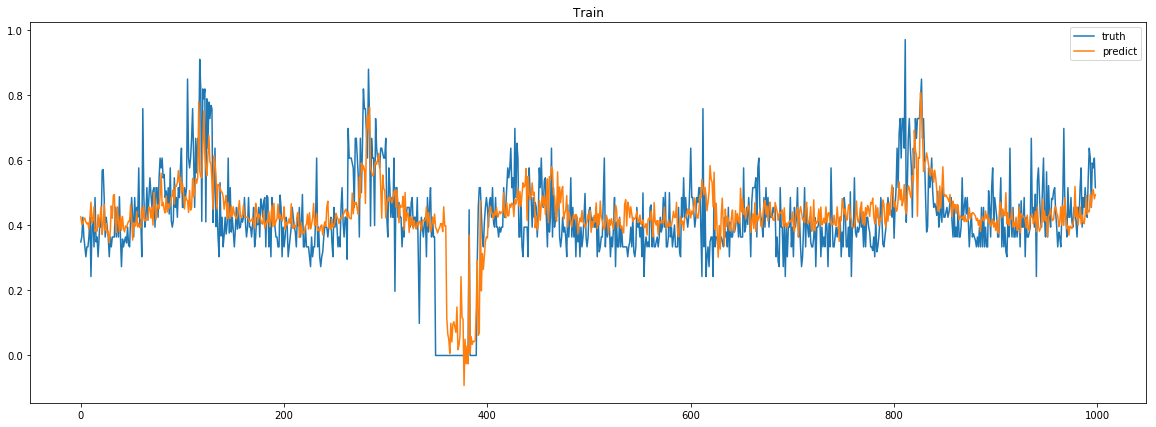

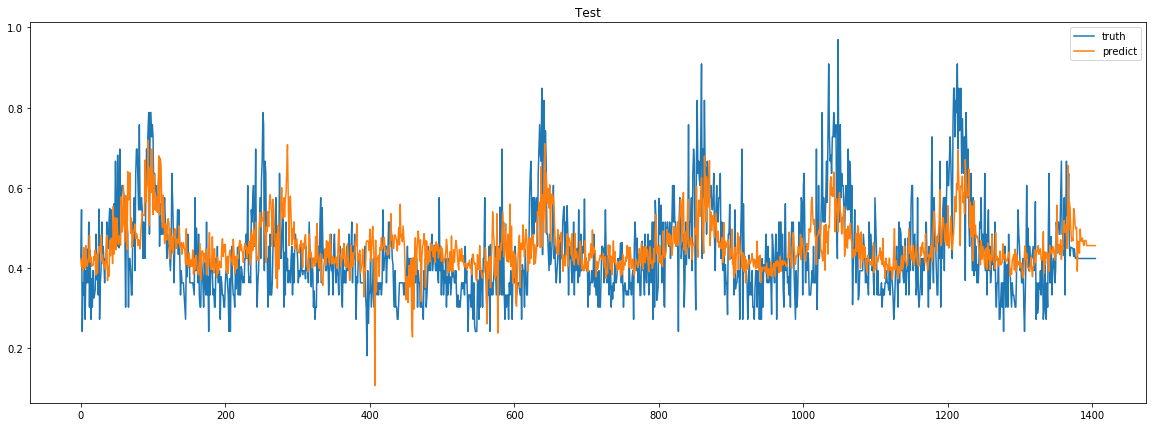

In [42]:
classes = [0]
fig, ax = plt.subplots(figsize=(20,7))
ax.plot( trainY[1:1000,classes])
ax.plot( trainPredict[1:1000,classes])
plt.legend(['truth','predict'])
plt.title('Train')
plt.show()
fig, ax = plt.subplots(figsize=(20,7))
ax.plot( testY[:,classes])
ax.plot( testPredict[:,classes])
#ax.plot( testPredict_singal[:,classes])
plt.legend(['truth','predict'])
plt.title('Test')
plt.show()

In [43]:
raw_data = final_merge_temp[list_name_X].values[train_size+11:-1,classes]

In [44]:
predict_data = invert_scaler(scaler_train,0,testPredict)

import pickle

list_pickel = [time_plot,predict_data,raw_data,filename_list]

with open('filename.pickle', 'wb') as handle:
    pickle.dump(list_pickel, handle, protocol=pickle.HIGHEST_PROTOCOL)

import pickle
with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
time_plot,predict_data,raw_data,filename_list = b[0],b[1],b[2],b[3]

filename_list[2][41:]

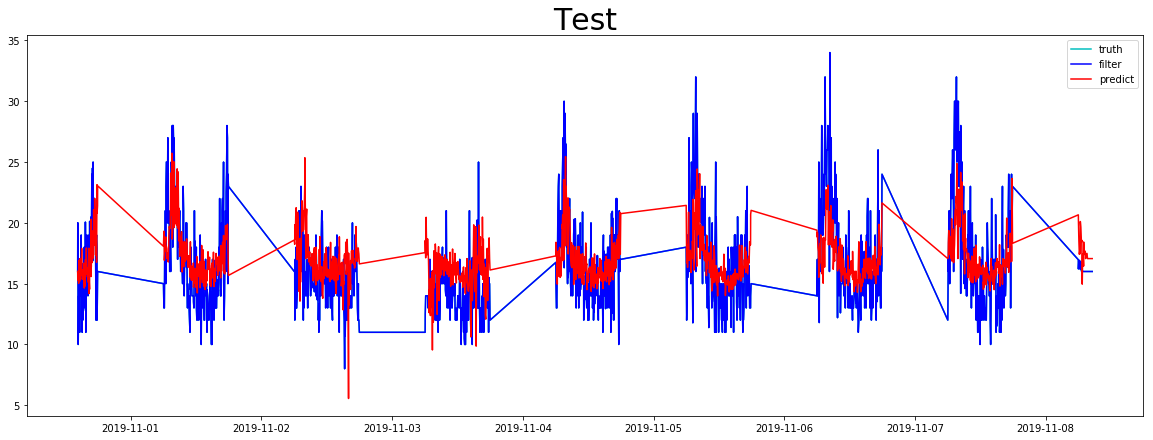

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(time_plot, raw_data , 'c')
ax.plot(time_plot, invert_scaler(scaler_train,0,testY) , 'b' )
ax.plot(time_plot, predict_data,'r')
plt.title('Test', fontsize=30)
plt.legend(['truth','filter','predict'])
plt.show()

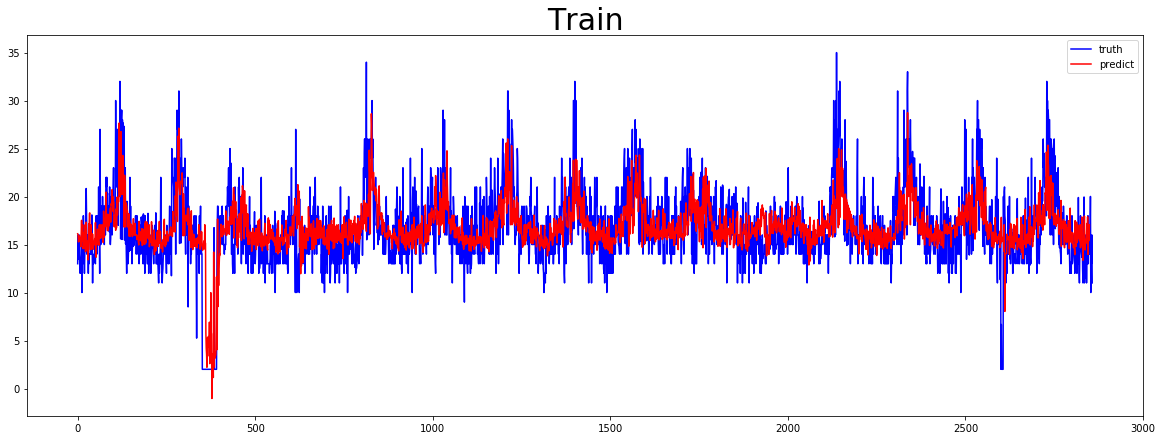

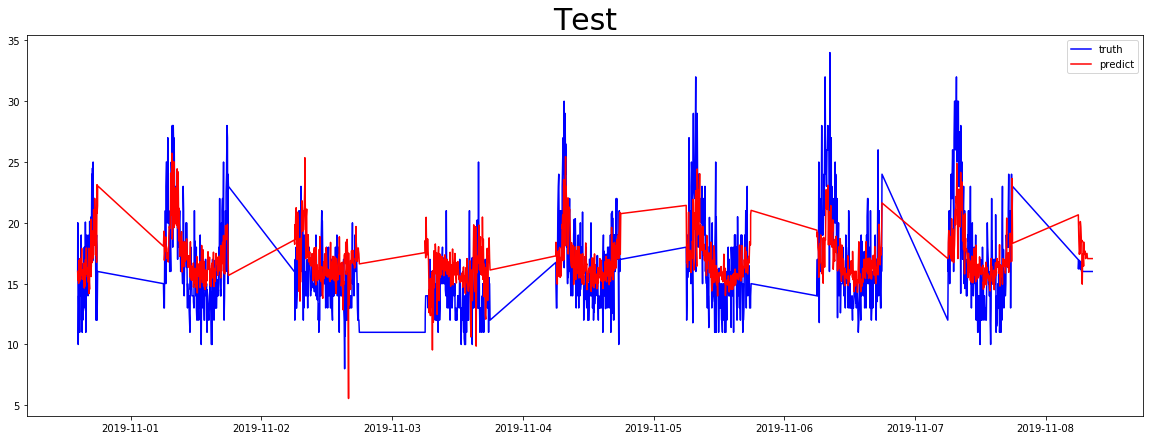

In [46]:
classes = [0]
fig, ax = plt.subplots(figsize=(20,7))
ax.plot( final_merge_temp[list_name_X].values[10:int(final_merge_temp[list_name_X].shape[0]*0.67)+10,classes], 'b' )
#ax.plot( invert_scaler(scaler_train,0,trainY) , 'b' )
ax.plot( invert_scaler(scaler_train,0,trainPredict), 'r')
plt.legend(['truth','predict'])
plt.title('Train', fontsize=30)
plt.show()
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(time_plot, raw_data , 'b')
#ax.plot(time_plot, invert_scaler(scaler_train,0,testY) , 'b' )
ax.plot(time_plot, predict_data,'r')
plt.title('Test', fontsize=30)
plt.legend(['truth','predict'])
plt.show()

In [20]:
def invert_scaler(scaler,index,data):
    mindata = scaler.data_min_[index]
    maxdata = scaler.data_max_[index]
    return data*(maxdata-mindata)+mindata

In [21]:
preprocessed_df_list = []
for i,file in enumerate(glob.glob('./raw_fpn/*')):
    print(file)
    data = pd.read_csv(file)
    list_data = data.values.tolist()
    result_list = []
    for i,data in enumerate(list_data):
        data_temp = []
        filename = data[0]
        subStr = re.findall(r'_time_(.+?).jpg',filename)  
        t1 = datetime.strptime(subStr[0], "%Y_%m_%d_%H_%M")
        data.append(t1)
        #data_temp.append(filename)
        data_temp.append(t1)
        #traffic_status = int(data[1]) + int(data[3]) + int(data[6]) + int(data[7]) + int(data[8])
        data_temp.append(data[1])
        data_temp.append(data[3])
        data_temp.append(data[6])
        data_temp.append(data[7])
        data_temp.append(data[8])
        data_temp.append(filename)
        result_list.append(data_temp)
        name_camera = re.findall(r'camera_(.+?)_time_',filename)
    columns = ['time' , name_camera[0]+'_motobike',  name_camera[0]+'_car', 
                   name_camera[0]+'_bus', name_camera[0]+'_train', name_camera[0]+'_truck', name_camera[0]+'_filename']
    preprocess = pd.DataFrame( result_list , columns = columns)
    preprocess = preprocess.sort_values(by='time',ascending=True)
    preprocessed_df_list.append(preprocess)

./raw_fpn/56df8416c062921100c143e4.csv
./raw_fpn/5a8256315058170011f6eac9.csv
./raw_fpn/56de42f611f398ec0c481290.csv
./raw_fpn/56df8381c062921100c143e2.csv
./raw_fpn/587c87e8b807da0011e33d45.csv
./raw_fpn/58abbf72bd82540010390ba4.csv
./raw_fpn/56df807bc062921100c143da.csv
./raw_fpn/56de42f611f398ec0c481287.csv
./raw_fpn/58ad69c4bd82540010390be7.csv
./raw_fpn/5a8279865058170011f6eaef.csv
./raw_fpn/587ee7d7b807da0011e33d55.csv
./raw_fpn/5a825b7d5058170011f6ead4.csv
./raw_fpn/585b284ac3f96200127dc500.csv
./raw_fpn/586e1f18f9fab7001111b0a5.csv
./raw_fpn/587ef5dfb807da0011e33d59.csv
./raw_fpn/56de42f611f398ec0c48128a.csv
./raw_fpn/56df8544c062921100c143e6.csv
./raw_fpn/56f8d743025e9511002786c5.csv
./raw_fpn/56de42f611f398ec0c481283.csv
./raw_fpn/58ad6214bd82540010390be2.csv
./raw_fpn/5ad0621c98d8fc001102e268.csv
./raw_fpn/56de42f611f398ec0c481298.csv
./raw_fpn/58af8a0bbd82540010390c25.csv
./raw_fpn/58746295b807da0011e33ccb.csv
./raw_fpn/5a10c79f02eb490011a0b0dd.csv
./raw_fpn/58746488b807da0

In [22]:
for i,df in enumerate(preprocessed_df_list):
    if i == 0:
        final_merge = df
    else: 
        final_merge = pd.merge(final_merge,df,on='time',how='outer')

In [23]:
final_merge = final_merge.interpolate(method='linear')

In [24]:
final_merge = final_merge.sort_values(by='time',ascending=True)

In [25]:
final_merge['5b0b74280e517b00119fd7f9_filename'].values[2858:-1]

array(['/home/duyle/Desktop/Khang/dataset/traffic/dataset_postman/5b0b74280e517b00119fd7f9/camera_5b0b74280e517b00119fd7f9_time_2019_10_31_14_5.jpg',
       '/home/duyle/Desktop/Khang/dataset/traffic/dataset_postman/5b0b74280e517b00119fd7f9/camera_5b0b74280e517b00119fd7f9_time_2019_10_31_14_10.jpg',
       nan, ..., nan, nan, nan], dtype=object)

In [26]:
time_plot = final_merge['time'].astype('O')[train_size+11:-1]

In [186]:
filename_list = final_merge['5b0b74280e517b00119fd7f9_filename'][train_size+11:-1].tolist()

In [6]:
from PIL import Image 
from IPython import display
from IPython.display import clear_output
import time

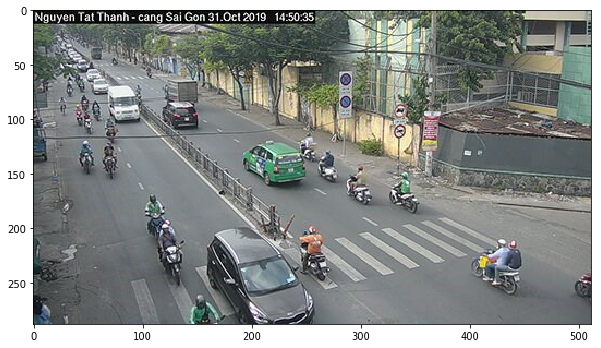

In [7]:
i = 0
fig, ax = plt.subplots(figsize=(10,10))
image_list = []
for image in filename_list:
    try:
        image = Image.open(image)
        image_list.append(image)
        #ax.clf()
    except:
        pass
    i = i + 1
    if i > 10:
        break
for image in image_list:
    ax.imshow(image)
    display.display(fig)
    #ax.show()
    time.sleep(0.5)
    clear_output()























preprocessed_df_list = []
for i,file in enumerate(glob.glob('./raw_fpn/*')):
    print(file)
    data = pd.read_csv(file)
    list_data = data.values.tolist()
    result_list = []
    for i,data in enumerate(list_data):
        data_temp = []
        filename = data[0]
        subStr = re.findall(r'_time_(.+?).jpg',filename)  
        t1 = datetime.strptime(subStr[0], "%Y_%m_%d_%H_%M")
        data.append(t1)
        #data_temp.append(filename)
        data_temp.append(t1)
        #traffic_status = int(data[1]) + int(data[3]) + int(data[6]) + int(data[7]) + int(data[8])
        data_temp.append(data[1])
        #data_temp.append(data[3])
        #data_temp.append(data[6])
        #data_temp.append(data[8])
        data_temp.append(filename)
        result_list.append(data_temp)
        name_camera = re.findall(r'camera_(.+?)_time_',filename)
    columns = ['time' , name_camera[0]+'_motobike', 'filename']
    preprocess = pd.DataFrame( result_list , columns = columns)
    preprocess = preprocess.sort_values(by='time',ascending=True)
    preprocessed_df_list.append(preprocess)

In [175]:
for i,df in enumerate(preprocessed_df_list):
    if i == 0:
        final_merge = df
    else: 
        final_merge = pd.merge(final_merge,df,on='time',how='outer')
final_merge = final_merge.interpolate(method='linear')
final_merge = final_merge.sort_values(by='time',ascending=True)

In [176]:
final_merge.describe().values[1,30]

116.67775955003515

In [177]:
np.argmax(final_merge.describe().values, axis=1)

array([ 0, 30, 24,  0, 30, 30, 30, 30])

In [91]:
np.sort(final_merge.describe().values[1,:])

array([  2.        ,   7.3582142 ,   9.21291305,   9.89137567,
        10.0865948 ,  10.08858683,  10.25064448,  10.26587767,
        10.43379423,  10.44492618,  10.46236811,  10.47679869,
        10.54886337,  10.74630888,  10.77302554,  10.79962503,
        10.91633466,  11.02284978,  11.07218186,  11.08155613,
        11.3073588 ,  11.34790251,  11.47679869,  11.54441059,
        11.71607687,  12.26974455,  12.2802906 ,  12.30278884,
        12.50316382,  12.54909773,  12.74736349,  12.84509023,
        12.87672838,  12.91586595,  12.98675885,  13.0719475 ,
        13.13803609,  13.14635575,  13.21256152,  13.31509257,
        13.31790485,  13.59456292,  13.62795875,  13.70049215,
        13.75509726,  13.77630654,  13.84040309,  13.96238575,
        14.24876963,  14.2765409 ,  14.4605109 ,  14.59139911,
        14.69228966,  14.78216546,  14.94082494,  15.12655261,
        15.36383876,  15.52214671,  15.96566674,  16.04171549,
        16.20635107,  16.2873213 ,  16.42887274,  16.57

In [82]:
np.argsort(final_merge.describe().values[1,:])

array([ 70,  74, 102,  25,   9,  64,  61, 126,  80, 110,  60,  45,  23,
       115,  28,  66,  65, 114, 125, 108,  68,  81,  83,  32,  98,  87,
        88,  12, 127,  20,  76, 118,  27, 120,  44,  18,  50,  40,  91,
        46,  34, 104, 103,  77,  86,  58,  35, 117, 112,  94,  36, 123,
       116,  47, 124,  90,  69,  72,  97,  82,  43,  54,  57,  11,  48,
        89,  33,  92,  29,  37,  84, 119,  56,  59,  85,   2,  55,   1,
        15,  78,  52,   7,  95,  93, 122, 121,  24, 111,  51,  71, 100,
         8,  62,  41,  38,  26,  67,  14,  22, 113,  21,  39,  96,  53,
        31,   0,  16, 128, 106,   4,  75,  49, 109,  73,   3,   6,  79,
        10,  19,  17, 101,  42, 105,  99,  13, 107,  63,   5,  30])

In [62]:
final_merge.describe().values[1,:]

array([ 41.13639559,  19.1672135 ,  18.91715491,  44.73412233,
        41.87063511, 108.69932037,  44.78392313,  20.33348957,
        35.38106398,  10.0865948 ,  46.17904851,  16.57077572,
        12.30278884,  55.24466839,  37.08120459,  19.24021561,
        41.53070073,  46.8571596 ,  13.0719475 ,  46.36817436,
        12.54909773,  38.16967424,  37.6304195 ,  10.54886337,
        22.21513944,   9.89137567,  36.23986407,  12.87672838,
        10.77302554,  17.28814155, 116.67775955,  41.09128193,
        11.54441059,  17.02531052,  13.31790485,  13.84040309,
        14.4605109 ,  18.02683384,  36.19029763,  39.75732365,
        13.14635575,  35.73189595,  49.36301851,  16.20635107,
        12.98675885,  10.47679869,  13.31509257,  14.78216546,
        16.61530349,  43.97527537,  13.13803609,  24.4572299 ,
        19.91246778,  40.31392079,  16.2873213 ,  18.91738927,
        18.45043356,  16.42887274,  13.77630654,  18.75415983,
        10.46236811,  10.25064448,  35.48148582, 103.06

In [95]:
final_merge.columns[106]

'58744e3eb807da0011e33cb7_motobike'